In [1]:
#import pairs_backtest as pb
import talib 
import datetime as dt #in-built module
import pandas as pd
from pandas_datareader import data
import yfinance as yf
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path
import os
from tqdm import tqdm   
from pairs_backtest import kalman_lib as kalman
from pairs_backtest import find_pairs
from pairs_backtest import utils
import glob
import datetime as dt 

In [2]:
def load_existing_pairs_csv (backtest_day, type = 'last_result'):
    date = dt.datetime.today().strftime('%Y_%m_%d')
    if os.path.isfile("pairs_%s.csv"%date): #if file exists
      df = pd.read_csv("pairs_%s.csv"%date)
      return df
    elif type == 'allUS': # if file does not exist, find pairs
      df = find_pairs.get_US_allstock(lookback=backtest_day)
      score_matrix, pvalue_matrix, pairs = find_pairs.find_cointegrated_pairs(df)
      print (pairs)
      #find_pairs.save_txt(pairs)  #save all the pairs
      df_pairs = pd.DataFrame(pairs, columns = ['s1','s2','p-value'])
      df_pairs = df_pairs.sort_values(by=['p-value'])
      df_pairs.to_csv("pairs_%s.csv"%date)
      return df_pairs
    elif type == 'last_result':
        csv_files_date = []
        csv_files = glob.glob(os.path.join(os.getcwd(), 'pairs*.csv')) #get all the csv file (e.g. pairs_yyyy_mm_dd)
        for csv_file in csv_files:
           filename = os.path.split(csv_file)[1]
           date = str(filename[6:-4])
           date = dt.datetime.strptime(date ,'%Y_%m_%d').date()
           csv_files_date.append(date)
        max_date = max(csv_files_date)
        latest_path = os.getcwd()+'\pairs_%s_%s_%s.csv'%(max_date.year,max_date.month,max_date.day)
        print('Latest path of existing pairs which passed cointegration test:',latest_path)
        df = pd.read_csv(latest_path,index_col=0)
        #print (df)
        return df
    else:
       raise Exception("Please specify 'TYPE'") 

def init():
    if not os.path.exists('log'):
        os.makedirs('log')
    if not os.path.exists('pairs_data'):
       os.makedirs('pairs_data')
    if not os.path.exists('Changing'):
       os.makedirs('Changing')
    if not os.path.exists('trades'):
       os.makedirs('trades')
    dir = 'py_plot'
    for f in os.listdir(dir):
      os.remove(os.path.join(dir, f))

def get_data(code,start,end):
    data = yf.Ticker(code)
    data = data.history(start = start, end = end)
    #data.index = data.index.strftime('%d/%m/%Y')
    return data


def delete_folder_contents(folder_path):
    # Iterate over all the items in the folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)

        # Check if the item is a file
        if os.path.isfile(item_path):
            # Delete the file
            os.remove(item_path)
        # Check if the item is a subfolder
        elif os.path.isdir(item_path):
            # Recursively delete the subfolder and its contents
            delete_folder_contents(item_path)
            # Delete the empty subfolder
            os.rmdir(item_path)

#df = load_existing_pairs_csv (270)
#print(df)

In [3]:

global date
date = dt.datetime.now()
date ='%s_%s_%s'%(date.year,date.month,date.day)
backtest_day = 730
len_constrain_day = 365
market = 'US'
#market = 'HK'
start = dt.datetime.now()- dt.timedelta(days=backtest_day)
end = dt.datetime.now()
TypeOfFindingParis = 'last_result' #last_result


init()
def find_changing_pairs( len_constrain_day = 365):
    '''
    Return: dataframe of the changing pairs
    
    '''
    delete_folder_contents('pairs_data')
    
    pairs = load_existing_pairs_csv(backtest_day = backtest_day, type = 'allUS')
    print (pairs)
    df_changing_pairs = pd.DataFrame(columns =['first_stock','second_stock','from_date','from_signal','To_date','To_signal','Hedge Ratio'])
    for pair in tqdm(pairs.iterrows()):
        #print (pair)
        first_instrument = pair[1]['s1']
        second_instrument = pair[1]['s2']

        df_1 = get_data(first_instrument,start,end)
        df_2 = get_data(second_instrument,start,end)
        common_index = (df_1.index).intersection(df_2.index)
        df_1 = df_1.loc[common_index].copy()
        df_2 = df_2.loc[common_index].copy()
        if len(common_index) > len_constrain_day:
            df, sharpe, half_life = kalman.backtest(df_1['Adj Close'], df_2['Adj Close'])
            df = df.dropna()
            df = df[['x','y','hr','zScore','numUnits','cum rets']]
            df.to_csv('pairs_data/%s-%s.csv' % (first_instrument,second_instrument))
            #find_changing_pairs:
            #changing_pairs = changing_pairs.append(utils.changing_pairs_dict(first_instrument,second_instrument,df = df), ignore_index = True)
            changing_pairs = utils.changing_pairs_dict(first_instrument,second_instrument,df = df)
            if changing_pairs is not None:
                pairs_dict = pd.DataFrame.from_dict(changing_pairs,orient='index').T
                df_changing_pairs= pd.concat([df_changing_pairs,pairs_dict], ignore_index = True)
            kalman.py_plot(df,date,first_instrument,second_instrument)
            #fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize=(14,20))
            #df[['x','y']].plot(ax=ax1)
            #df[['cum rets']].plot(ax = ax2)
            #df['zScore']= df['zScore'].fillna(0)
            #df['zScore'].plot(ax = ax3)
            #plt.tight_layout()
            #plt.show()
            #s = pd.Series(stat_raw)
            #combined = pd.concat([combined,s],axis=1)

    df_changing_pairs.to_csv('Changing/changing_pairs_%s.csv'%(date))
    return df_changing_pairs
    
#find_changing_pairs()

In [4]:

def load_latest_changing_pairs():
    directory = 'Changing'
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    csv_files_date = []
    #extract the date of the existing directory
    for csv_file in csv_files:
        filename = os.path.split(csv_file)[1]
        date = str(filename[15:-4])
        date = dt.datetime.strptime(date ,'%Y_%m_%d').date()
        csv_files_date.append(date)

    max_date = max(csv_files_date)
    # Get the latest CSV file
    latest_path = directory+'\changing_pairs_%s_%s_%s.csv'%(max_date.year,max_date.month,max_date.day)
    print('Latest path:',latest_path)
    df = pd.read_csv(latest_path,index_col=0)
    
    return df,max_date

#df, latest_date= load_latest_pairs()
#df



In [5]:
#######Get pairs that can be traded######
#can_trade = df[df['To_signal']!=0]
#can_trade


In [8]:
from ib_insync import *
util.startLoop()  # only use in interactive environments (i.e. Jupyter Notebooks)
ib = IB()
client_id = 1
flag = True 
while flag:
    try:
        ib.connect(host='127.0.0.1', port=4001, clientId=client_id)
    except TimeoutError:
        client_id += 1
        print ('trying client_id: %i'%client_id)
    else:
        flag = False



In [9]:
def get_position(): 
    position = ib.positions()
    position_list = []
    for item in position:
        dictionary = {'symbol':item.contract.symbol,
                    'position':item.position,
                    'avgCost':item.avgCost}
        position_list.append(dictionary)
    return position_list

###Check current position###
position_list = get_position()
print(position_list)

[{'symbol': 'ROL', 'position': 102.0, 'avgCost': 42.3098039}, {'symbol': 'XYL', 'position': -51.0, 'avgCost': 110.8093608}]


In [19]:
Capital = 10000

if  len(position_list) == 0:
    
    find_changing_pairs()
    df,latest_date = load_latest_changing_pairs()

    can_trade = df[(df['To_signal']!=0)&(abs(df['Hedge Ratio'])>2)]
    
    if can_trade.empty:
       print ('Empty changing pair')
    else:
        #print(df) 
        #print(can_trade)
        first_row = can_trade.iloc[0]

        #print(first_row)
        x_stock = first_row['first_stock']
        y_stock = first_row['second_stock']
        ratio = abs(round(first_row['Hedge Ratio']))
        x_df = get_data(x_stock,start,end)
        y_df = get_data(y_stock,start,end)
        common_index = (x_df.index).intersection(y_df.index)
        if len(common_index) > len_constrain_day:
            x_df = x_df.loc[common_index].copy()
            y_df = y_df.loc[common_index].copy() 
            df, sharpe, _ = kalman.backtest(x_df['Adj Close'], y_df['Adj Close']) #df1 = x; df2 = y
            df = df.dropna()
            df.to_csv('log/%s_%s.csv'%(x_stock,y_stock))

            ##save trading record
            dir = 'trades'
            for f in os.listdir(dir):
                os.remove(os.path.join(dir, f))
            first_row.to_frame().T.to_csv('trades/last_change_of_pair.csv')


            if first_row['To_signal']==1:
                #Long second (y); Short first (x) * hedge ratio

                one_unit_cost = df['x'][-1]*ratio+df['y'][-1] 
                current_spread = df['y'][-1]  - df['x'][-1]*ratio
                one_unit_quantity = round(Capital/one_unit_cost)

                x_contract = Stock(x_stock,exchange='SMART',currency='USD')
                ib.qualifyContracts(x_contract)
                x_contract_quantity = one_unit_quantity*ratio
                order1 = MarketOrder('SELL', x_contract_quantity)
                ib.placeOrder(x_contract, order1)
                print('Placed: SELL %s %s'%(x_contract,x_contract_quantity))

                y_contract = Stock(y_stock,exchange='SMART',currency='USD')
                ib.qualifyContracts(y_contract)
                y_contract_quantity = one_unit_quantity
                order2 = MarketOrder('BUY', y_contract_quantity)
                ib.placeOrder(y_contract, order2)
                print('Placed: BUY %s %s'%(y_contract,y_contract_quantity))
                print('Short %s: %s * %i; Long %s: %s'%(x_stock,x_contract_quantity,ratio,y_stock,y_contract_quantity,))
            elif first_row['To_signal']== -1:
                
                #Short second (y); Long first (x) * hedge ratio
                one_unit_cost = df['x'][-1]*ratio+df['y'][-1] 
                current_spread = df['y'][-1]  - df['x'][-1]*ratio
                one_unit_quantity = round(Capital/one_unit_cost)
    
                x_contract = Stock(x_stock,exchange='SMART',currency='USD')
                ib.qualifyContracts(x_contract)
                x_contract_quantity = one_unit_quantity*ratio
                order1 = MarketOrder('BUY', x_contract_quantity)
                ib.placeOrder(x_contract, order1)
                print('Placed: BUY %s %s'%(x_contract,x_contract_quantity))
    
                y_contract = Stock(y_stock,exchange='SMART',currency='USD')
                ib.qualifyContracts(y_contract)
                y_contract_quantity = one_unit_quantity
                order2 = MarketOrder('SELL', y_contract_quantity)
                ib.placeOrder(y_contract, order2)
                print('Placed: SELL %s %s'%(y_contract,y_contract_quantity))
                print('Long %s: %s; Short %s: %s * %i'%(x_stock,x_contract_quantity,y_stock,y_contract_quantity,ratio))
elif len(position_list) ==2:
    print('There are two stocks holding')

    ##check with last changing record
    last_changing = pd.read_csv('trades/last_change_of_pair.csv')
    last_changing_first = (last_changing['first_stock'].values[0])
    last_changing_second = (last_changing['second_stock'].values[0])
    last_changing_list = (last_changing_first,last_changing_second)

    first_instrument_symbol = position_list[0]['symbol']
    second_instrument_symbol = position_list[1]['symbol']
    symbol_list = (first_instrument_symbol,second_instrument_symbol)
 
    if set(last_changing_list) == set (symbol_list):
        print('checking with last changing record: passed')
        x_df = get_data(last_changing_first,start,end)
        y_df = get_data(last_changing_second,start,end)
        common_index = (x_df.index).intersection(y_df.index)
        x_df = x_df.loc[common_index].copy()
        y_df = y_df.loc[common_index].copy()
        df, sharpe, _ = kalman.backtest(x_df['Adj Close'], y_df['Adj Close']) #df1 = x; df2 = y
        df = df.dropna()
        path = 'log/%s_%s.csv'%(last_changing_first,last_changing_second)
        df.to_csv(path)
        changing_dict = utils.changing_pairs_dict(last_changing_first,last_changing_second,df = df)
        print(df.tail())
        #####Close all the position######
        if changing_dict is not None: #Changed signal
            if changing_dict['To_signal'] == 0 or df['numUnits'][-1] == 0:
              for stock in position_list:
                temp_contract = Stock(stock['symbol'],exchange='SMART',currency='USD')
                ib.qualifyContracts(temp_contract)
                print('Closing %s with %s'%(stock['symbol'],stock['position']))
                if stock['position'] > 0: 
                    temp_order = MarketOrder('SELL', stock['position'])
                    ib.placeOrder(temp_contract, temp_order)
                elif stock['position'] < 0:
                   temp_order = MarketOrder('BUY', abs(stock['position']))
                   ib.placeOrder(temp_contract, temp_order)
                print('Close all the positions')
        print('No Change for pairs/n')
        print('Saving to ', path)
        print(df.tail()[['y','x','hr','zScore','numUnits']])
else:
   print("More than 2 stocks")
    

There are two stocks holding
checking with last changing record: passed
                                    y          x        hr    spread  zScore  \
Date                                                                           
2023-12-21 00:00:00-05:00  111.690002  42.810001 -2.498671  4.721899   0.771   
2023-12-22 00:00:00-05:00  112.639999  42.980000 -2.502317  5.090434   1.137   
2023-12-26 00:00:00-05:00  113.620003  43.270000 -2.506325  5.171330   1.157   
2023-12-27 00:00:00-05:00  114.379997  43.639999 -2.509995  4.843803   0.738   
2023-12-28 00:00:00-05:00  114.320000  43.770000 -2.512795  4.334957   0.138   

                          long entry long exit  num units long  short entry  \
Date                                                                          
2023-12-21 00:00:00-05:00      False      True             0.0        False   
2023-12-22 00:00:00-05:00      False     False             0.0        False   
2023-12-26 00:00:00-05:00      False     False     

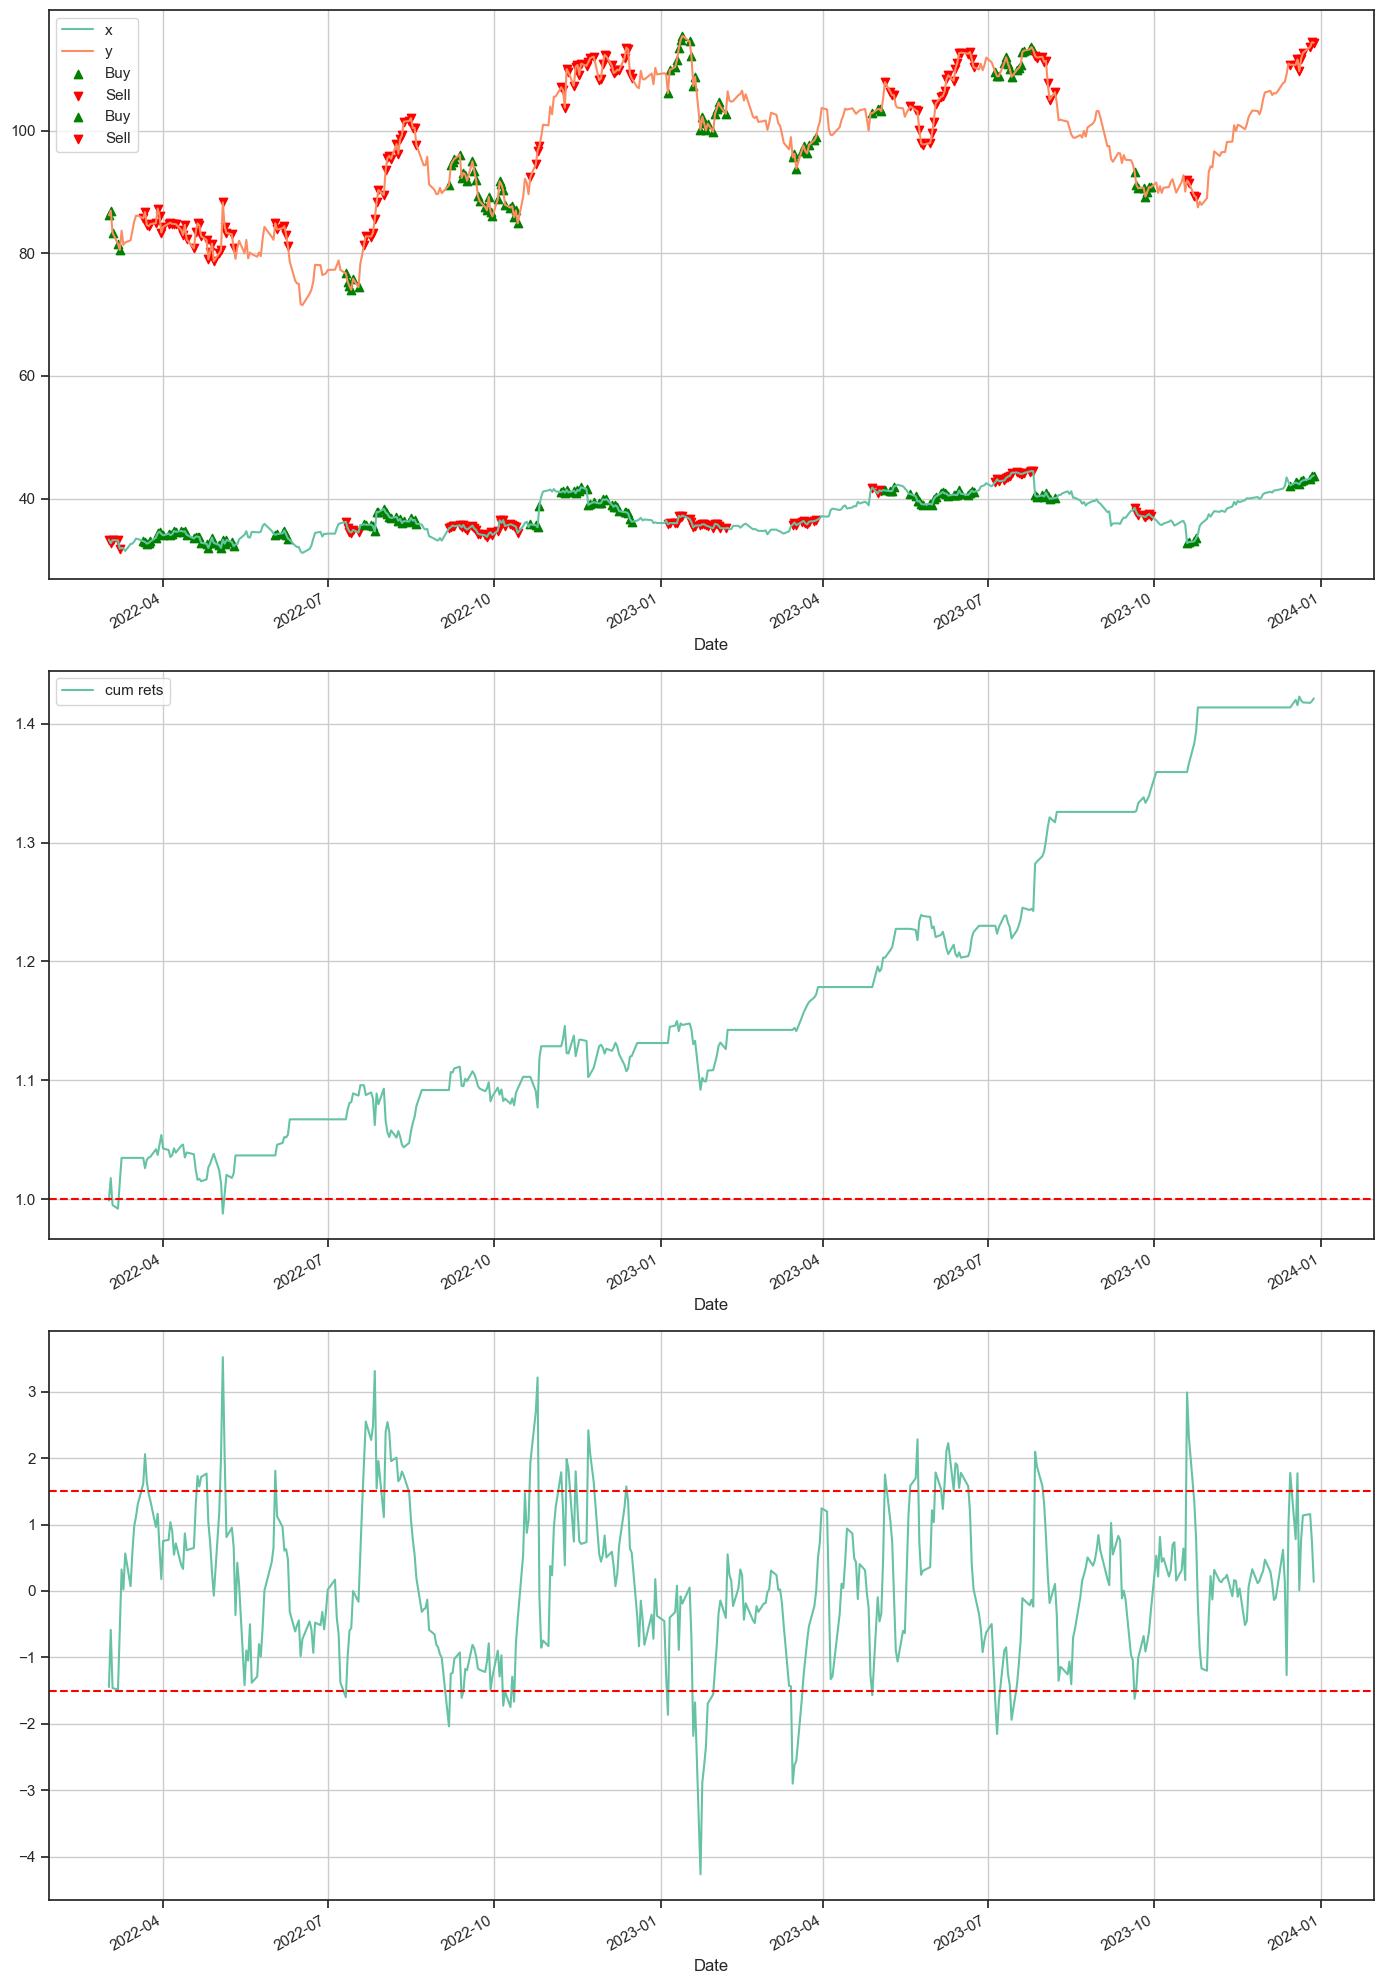

In [20]:
axes_tuple = kalman.py_plot(df,date,last_changing_first,last_changing_second)

In [12]:
df.tail()

,y,x,hr,spread,zScore,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets,X_sell_price,Y_Buy_price,X_Buy_price,Y_sell_price
Date,,,,,,,,,,,,,,,,,,,
2023-12-21 00:00:00-05:00,111.690002,42.810001,-2.498671,4.721899,0.771,False,True,0.0,False,False,-1.0,-1.0,0.003287,-0.003287,1.419486,NaN,NaN,42.810001,111.690002
2023-12-22 00:00:00-05:00,112.639999,42.980000,-2.502317,5.090434,1.137,False,False,0.0,False,False,-1.0,-1.0,0.001674,-0.001674,1.417812,NaN,NaN,42.980000,112.639999
2023-12-26 00:00:00-05:00,113.620003,43.270000,-2.506325,5.171330,1.157,False,False,0.0,False,False,-1.0,-1.0,0.000364,-0.000364,1.417448,NaN,NaN,43.270000,113.620003
2023-12-27 00:00:00-05:00,114.379997,43.639999,-2.509995,4.843803,0.738,False,False,0.0,False,False,-1.0,-1.0,-0.001463,0.001463,1.418910,NaN,NaN,43.639999,114.379997
2023-12-28 00:00:00-05:00,114.320000,43.770000,-2.512795,4.334957,0.138,False,False,0.0,False,False,-1.0,-1.0,-0.002269,0.002269,1.421179,NaN,NaN,43.770000,114.320000


In [13]:
ib.disconnect()

In [14]:
position_list

[{'symbol': 'ROL', 'position': 102.0, 'avgCost': 42.3098039},
 {'symbol': 'XYL', 'position': -51.0, 'avgCost': 110.8093608}]

In [15]:
df,latest_date = load_latest_changing_pairs()
df

Latest path: Changing\changing_pairs_2023_12_15.csv


,first_stock,second_stock,from_date,from_signal,To_date,To_signal,Hedge Ratio
0,FSLR,SJM,2023-12-14,-1.0,2023-12-15,0.0,-0.768170
1,DOW,TSN,2023-12-14,-1.0,2023-12-15,0.0,-0.934137
2,IQV,NDSN,2023-12-14,1.0,2023-12-15,0.0,-1.103223
3,ROL,XYL,2023-12-14,0.0,2023-12-15,-1.0,-2.484116
4,FSLR,KR,2023-12-14,0.0,2023-12-15,1.0,-0.288450
5,FE,IFF,2023-12-14,0.0,2023-12-15,-1.0,-1.947821
6,COST,PCAR,2023-12-14,0.0,2023-12-15,1.0,-0.149546
7,AMP,APH,2023-12-14,0.0,2023-12-15,-1.0,-0.258822
8,EBAY,FTNT,2023-12-14,0.0,2023-12-15,-1.0,-1.274510
9,ELV,KMI,2023-12-14,0.0,2023-12-15,-1.0,-0.036601
